In [1]:
import os
import qiime2
import numpy as np
import pandas as pd
from skbio import TreeNode
%matplotlib inline

table_art = qiime2.Artifact.load('composition.biom.qza')
table = table_art.view(pd.DataFrame)

balance_art = qiime2.Artifact.load('balances.qza')
balances = balance_art.view(pd.DataFrame)

tree_art = qiime2.Artifact.load('correlated_hierarchy.nwk.qza')
tree = tree_art.view(TreeNode)

taxa_art = qiime2.Artifact.load('taxa.qza')
taxa = taxa_art.view(pd.DataFrame)

metadata = pd.read_table('map.txt', index_col=0)

To get the 500 foot overview what the balances represent, let's first plot them on a heatmap.

Note that when constructing the highlights, the order is fixed.  This means that the first column will denote the numerator colors, and the second column will denote the denominator colors.

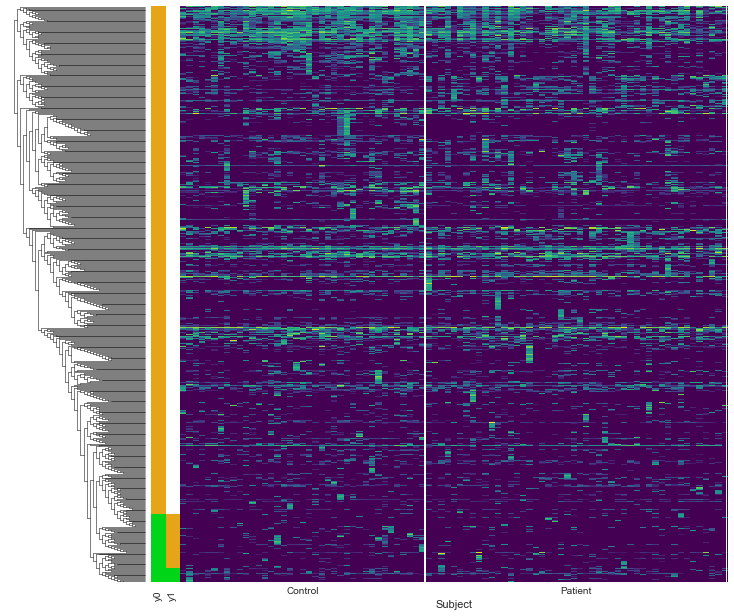

In [2]:
from gneiss.plot import heatmap

highlights = pd.DataFrame([['#00D617', '#E6A519'],
                           ['#00D617', '#E6A519']],
                          index=['y0', 'y1'], 
                          columns=['numerator', 'denominator'])

_ = heatmap(np.log(table), tree, mdvar=metadata.Subject, 
            highlights=highlights, figsize=(10, 10))

We can symmetrize the values in the heatmap to try to make the differences between the classes more apparent.

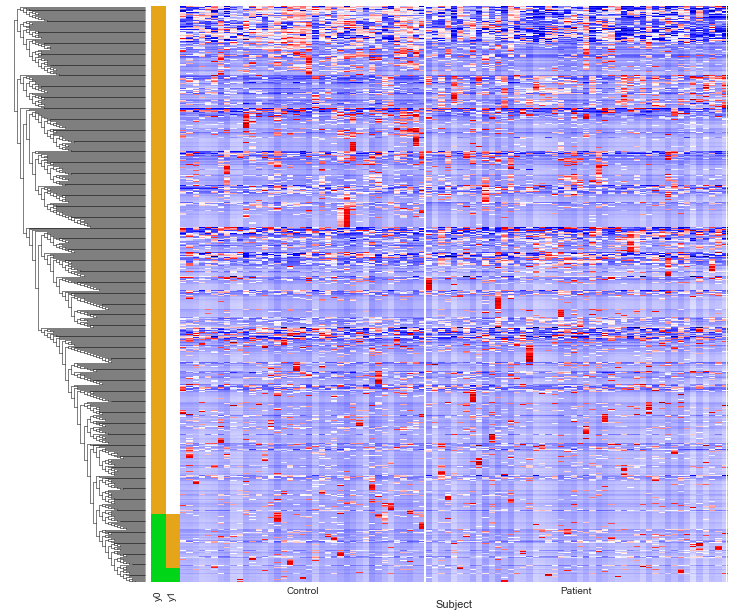

In [3]:
from gneiss.sort import ladderize
from skbio.stats.composition import clr, centralize

ctable = pd.DataFrame(clr(centralize(table)), index=table.index, columns=table.columns)

sorted_tree = ladderize(tree)

_ = heatmap(ctable, sorted_tree, mdvar=metadata.Subject, 
            highlights=highlights, figsize=(10, 10), cmap='seismic')

Now let's build the boxplots. We'll group by subject to see how well this balance can separate the controls from the CFS patients.

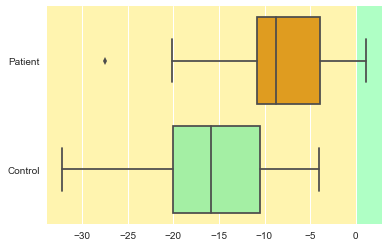

In [4]:
%matplotlib inline
from gneiss.plot import balance_boxplot, balance_barplots
data = pd.merge(balances, metadata, left_index=True, right_index=True)
ax = balance_boxplot('y0', data, y='Subject',
                     num_color='#FFF4AF', denom_color='#AFFFC5',
                     palette={'Patient': 'orange', 'Control': 'palegreen'})

As you can see from the above plot, this is a very clear separation. We could draw a line that performs classification at 75% accuracy looking at a single balance. This isn't accounting for all of the other balances that we have created. This suggests that the effect size between the controls and the CFS patients is actually quite large, since y0 is the very top balance with the largest variance.
Let's see what taxa make up these balances.

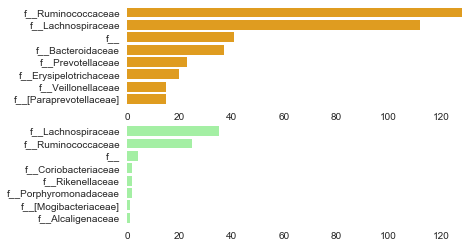

In [5]:
# parse out taxonomies such that each level of the taxonomy has its own column
taxa = pd.DataFrame(taxa.Taxon.apply(lambda x: x.split(';')).values.tolist(),
                    columns=['kingdom', 'phylum', 'class', 'order', 
                             'family', 'genus', 'species'],
                    index=taxa.index)

axes = balance_barplots(tree, 'y0', header='family', 
                        feature_metadata=taxa, ndim=8,
                        denom_color='palegreen', 
                        num_color='orange')

We can see here that Prevotellaceae and Paraprevotellaceae are present here. These taxa were missed in the initial analyses, and are commonly associated with inflammation in previous studies. If we want to get the full list of taxa in each balance, we get these with the following command below.  Note that we want to use the `NUMERATOR` and `DENOMINATOR` variables so that we don't confuse the parts of the balance.

In [6]:
from gneiss.util import NUMERATOR, DENOMINATOR
num_taxa = taxa.loc[tree.find('y0').children[NUMERATOR].subset()]
denom_taxa = taxa.loc[tree.find('y0').children[DENOMINATOR].subset()]

These taxonomy summaries can be saved to disk for further investigation. Or we can use them for visualization later.
Let's start by investigating some of model statistics. To do this, we'll need to unpack the results from the visualization.

In [7]:
viz = qiime2.Visualization.load('regression_summary.qzv')
viz.export_data('regression_summary_dir')

pvals = pd.read_csv('regression_summary_dir/pvalues.csv', index_col=0)
resid = pd.read_csv('regression_summary_dir/residuals.csv', index_col=0)

Now let's try to figure out exactly what we want to plot. For starters, let's resize the size of the node according to the pvalue for identifying a subject, and highlight the residual values for each internal node.

In [8]:
pvals.columns

Index(['Intercept', 'Subject[T.Patient]', 'Sex[T.Male]', 'Age', 'BMI',
       'sCD14ugml', 'LBPugml', 'LPSpgml'],
      dtype='object')

In [9]:
t = tree.copy()
for n in t.postorder():
    n.color = '#FF00FF'  # color all nodes magenta    
    if not n.is_tip():
        n.pvalue = -np.log(pvals.loc[n.name, 'Subject[T.Patient]'])
        n.resid = (resid.loc[n.name]**2).mean()
    if n.name in num_taxa.index:
        n.edge_color = '#F3BA2C'  # orange
    elif n.name in denom_taxa.index:
        n.edge_color = '#5DD17D'  # green
    else:
        n.edge_color = '#C2C2C2'  # grey

In [10]:
from gneiss.plot import radialplot
from bokeh.io import show, output_notebook
output_notebook()
p = radialplot(t, node_size='pvalue', 
               node_color='color', edge_color='edge_color',
               hover_var='resid')
show(p)

Loading BokehJS ...

In conclusion, regression on balances is a very powerful tool for obtaining information about the underlying community structure and inferring the overall effect of environmental variables on a given community.